<h1 style="text-align: center;font-family: Babas;" markdown="1">Self-Attention</h1>


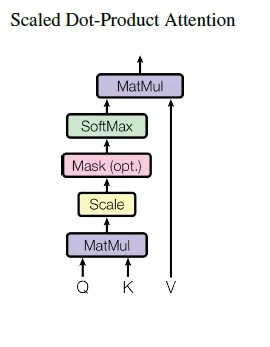

In [16]:
import numpy as np
import math

We will start by initially creating q,k,v vectors of lenght 8 for a sentence of size 4 eg, My name is Ankit

In [34]:
L, d_k, d_v= 4, 8, 8 # L is the length of input sequence, 8 is the size of these vectors
q = np.random.randn(L, d_k) # Randomly initialized Query vector
k = np.random.randn(L, d_k) # Randomly initialized Key vector
v = np.random.randn(L, d_v) # Randomly initialized Value vector




In [18]:
print("Q\n", q)
print("K\n", k)
print("V\n", v)

Q
 [[ 0.86077752  0.05751135  0.02612362 -1.52325092  0.03492118 -0.13281609
   0.43783375 -1.21276692]
 [-0.00756158 -1.06221626  0.68074476 -1.29058129  0.71078074  0.52764515
   0.57507123 -1.14201261]
 [-0.73302907  0.59482344  0.87388035  0.53343665 -0.14270126 -0.52265778
   1.398796   -0.66534455]
 [ 1.9993377   0.65475826 -0.2197526  -0.19100261  0.20201535 -0.51793055
  -0.01064389 -0.55998013]]
K
 [[-0.83396908  0.41413147  0.45901608 -0.77657655  1.76275194  1.42835591
   1.61020357  1.23936644]
 [-1.04071218  0.44378557 -1.10591326 -0.64369719  1.13178501 -1.05413332
   0.63961569 -0.37833217]
 [ 0.83823485  0.34348399 -0.16759105  1.10379012 -0.33623799  0.32330632
   0.1894233   1.05247889]
 [ 0.77600508 -0.00852938 -0.50080629 -0.93575148 -0.13079465  0.40881099
  -0.29409067 -0.76095374]]
V
 [[-1.16632699e-01  2.55035812e+00 -3.58315997e-01 -1.96968652e-01
   1.77860317e-01 -1.77182106e+00 -1.19170528e+00  4.45454530e-01]
 [ 1.57809855e-03  1.86622691e+00 -2.81045186e+0

<!-- 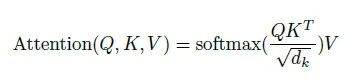 -->





$$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $$



> Every single word has to look every other word just too see if that word has his affinity towards other word or not!

In [19]:
np.matmul(q, k.T) # (4*8) X (8*4) = (4*4)

array([[-0.4253449 ,  0.99972615, -2.19259723,  2.81501114],
       [ 2.39832175,  0.66249943, -3.07122301,  1.69257081],
       [ 1.27418179,  1.25289575, -0.52408412, -1.61079679],
       [-2.44361728, -0.44453139,  0.90005638,  2.025787  ]])

In [20]:
# We need to divide the above product with sqrt of d_k to minimize the variance and stabilize the gradients
q.var(), k.var(), np.matmul(q, k.T).var()

(0.6308301172110795, 0.6869282803035538, 3.05383269397103)

In [21]:
scaled = np.matmul(q,k.T)/math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(0.6308301172110795, 0.6869282803035538, 0.3817290867463787)

In [22]:
scaled

array([[-0.15038213,  0.35345657, -0.77520018,  0.99525673],
       [ 0.84793479,  0.23422892, -1.08584131,  0.59841415],
       [ 0.45049129,  0.44296554, -0.18529172, -0.56950267],
       [-0.86394918, -0.15716558,  0.31821798,  0.71622386]])

## Masking

* This is to keep words unaware of context from upcoming words in future.
* It's only required in decoder and not in encoder

In [23]:
mask= np.tril(np.ones((L,L)))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [24]:
mask[mask==0]=-np.infty
mask[mask==1]=0

In [25]:
mask

array([[  0., -inf, -inf, -inf],
       [  0.,   0., -inf, -inf],
       [  0.,   0.,   0., -inf],
       [  0.,   0.,   0.,   0.]])

In [26]:
print(scaled,"\n","-"*50,"\n",scaled+mask)

[[-0.15038213  0.35345657 -0.77520018  0.99525673]
 [ 0.84793479  0.23422892 -1.08584131  0.59841415]
 [ 0.45049129  0.44296554 -0.18529172 -0.56950267]
 [-0.86394918 -0.15716558  0.31821798  0.71622386]] 
 -------------------------------------------------- 
 [[-0.15038213        -inf        -inf        -inf]
 [ 0.84793479  0.23422892        -inf        -inf]
 [ 0.45049129  0.44296554 -0.18529172        -inf]
 [-0.86394918 -0.15716558  0.31821798  0.71622386]]


## Softmax

$$ \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} $$


In [27]:
def softmax(x): # Row adds up to 1 , It takes a vector of real numbers and transforms it into a probability distribution
    return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

In [28]:
attention= softmax(scaled+mask) # for decoder

In [29]:
attention # Shows which word has most focus on

array([[1.        , 0.        , 0.        , 0.        ],
       [0.6487857 , 0.3512143 , 0.        , 0.        ],
       [0.39650706, 0.39353425, 0.2099587 , 0.        ],
       [0.08972883, 0.18192158, 0.29264471, 0.43570489]])

In [30]:
new_v = np.matmul(attention, v) # (4*4) * (4*8) = (4*8)
new_v

array([[-0.1166327 ,  2.55035812, -0.358316  , -0.19696865,  0.17786032,
        -1.77182106, -1.19170528,  0.44545453],
       [-0.07511538,  2.31008145, -1.21954119, -0.06365512,  0.06633596,
        -0.93135608, -1.28311037,  0.16293552],
       [ 0.02286666,  1.79578362, -1.37110767, -0.58204897, -0.13428966,
        -0.3183717 , -1.03698363, -0.20974531],
       [-0.46446442,  0.38914755,  0.08105999, -0.85655942, -0.19815209,
         0.21228037,  0.17143911, -0.17945943]])

In [31]:
v

array([[-1.16632699e-01,  2.55035812e+00, -3.58315997e-01,
        -1.96968652e-01,  1.77860317e-01, -1.77182106e+00,
        -1.19170528e+00,  4.45454530e-01],
       [ 1.57809855e-03,  1.86622691e+00, -2.81045186e+00,
         1.82610234e-01, -1.39679007e-01,  6.21204991e-01,
        -1.45195975e+00, -3.58951794e-01],
       [ 3.26213261e-01,  2.38734698e-01, -5.85942847e-01,
        -2.74250552e+00, -7.13683509e-01,  6.65380473e-01,
         3.30151258e-02, -1.16742653e+00],
       [-1.26175033e+00, -5.71635740e-01,  1.82684702e+00,
        -1.59572850e-01,  4.62584545e-02,  1.45816899e-01,
         1.22296204e+00,  4.30366362e-01]])

## Complete function

In [32]:
def softmax(x):
    return ( np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

def scaled_dot_product_attention( q, k, v, mask=None): # mask is none by default and is in encoder setting which 
                                                       # can be changed to decoder by passing mask
    d_k=q.shape[-1]
    scaled= np.matmul(q, k.T)/math.sqrt(d_k)
    if mask is not None:
        scaled= scaled+mask
    attention= softmax(scaled)
    out=np.matmul(attention, v)
    return out, attention # new values , attention

In [33]:
values, attention= scaled_dot_product_attention(q, k, v, mask=mask)
print("Q\n", q)
print("-"*50)
print("K\n", k)
print("-"*50)
print("V\n", v)
print("-"*50)
print("Attention\n", attention)
print("-"*50)
print("New V\n", values)


Q
 [[ 0.86077752  0.05751135  0.02612362 -1.52325092  0.03492118 -0.13281609
   0.43783375 -1.21276692]
 [-0.00756158 -1.06221626  0.68074476 -1.29058129  0.71078074  0.52764515
   0.57507123 -1.14201261]
 [-0.73302907  0.59482344  0.87388035  0.53343665 -0.14270126 -0.52265778
   1.398796   -0.66534455]
 [ 1.9993377   0.65475826 -0.2197526  -0.19100261  0.20201535 -0.51793055
  -0.01064389 -0.55998013]]
--------------------------------------------------
K
 [[-0.83396908  0.41413147  0.45901608 -0.77657655  1.76275194  1.42835591
   1.61020357  1.23936644]
 [-1.04071218  0.44378557 -1.10591326 -0.64369719  1.13178501 -1.05413332
   0.63961569 -0.37833217]
 [ 0.83823485  0.34348399 -0.16759105  1.10379012 -0.33623799  0.32330632
   0.1894233   1.05247889]
 [ 0.77600508 -0.00852938 -0.50080629 -0.93575148 -0.13079465  0.40881099
  -0.29409067 -0.76095374]]
--------------------------------------------------
V
 [[-1.16632699e-01  2.55035812e+00 -3.58315997e-01 -1.96968652e-01
   1.77860317